In [1]:
%reload_ext autoreload
%autoreload 2
from IPython.display import display

In [2]:
import jsonlines
import glob
from collections import defaultdict

In [3]:
for f in glob.glob("../samples/anomaly_patterns/*.jsonl"):
    with jsonlines.open(f) as reader:
        aggr = defaultdict(int)
        aggr2 = defaultdict(int)
        for obj in reader:
            aggr[obj["anomaly_pattern"]] += 1
            aggr2[obj["anomaly_position"]] += 1
    if len(aggr) < 1:
        continue
    display(f, aggr, aggr2)

'../samples/anomaly_patterns/anomaly_patterns_20221018-105001.jsonl'

defaultdict(int,
            {'Single spike': 62,
             'Other normal': 172,
             'White noise': 34,
             'Level shift up': 71,
             'Level shift down': 180,
             'Transient level shift down': 20,
             'Sudden increase': 16,
             'Multiple spikes': 23,
             'Transient level shift up': 19,
             'Multiple dips': 10,
             'Steady increase': 21,
             'Single dip': 69,
             'Steady decrease': 2,
             'Fluctuations': 11,
             'Sudden decrease': 6})

defaultdict(int,
            {'anomaly_during_fault': 465,
             'no_anomaly': 206,
             'anomaly_outside_fault': 45})

'../samples/anomaly_patterns/anomaly_patterns_20221017-150244.jsonl'

defaultdict(int,
            {'Level shift down': 2,
             'White noise': 1,
             'Other normal': 9,
             'Single spike': 3})

defaultdict(int, {'anomaly_during_fault': 13, 'no_anomaly': 2})

'../samples/anomaly_patterns/anomaly_patterns_20221017-150023.jsonl'

defaultdict(int, {'Level shift down': 1})

defaultdict(int, {'anomaly_during_fault': 1})

'../samples/anomaly_patterns/anomaly_patterns_20221017-150108.jsonl'

defaultdict(int, {'Level shift down': 1})

defaultdict(int, {'anomaly_during_fault': 1})

'../samples/anomaly_patterns/anomaly_patterns_20221025-222246.jsonl'

defaultdict(int,
            {'Level shift up': 4,
             'Multiple dips': 1,
             'Level shift down': 6,
             'Single spike': 2,
             'Fluctuations': 1,
             'Sudden increase': 1,
             'Other normal': 13,
             'Transient level shift up': 1,
             'Steady increase': 5,
             'Transient level shift down': 1,
             'Multiple spikes': 1,
             'White noise': 1})

defaultdict(int,
            {'anomaly_outside_fault': 5,
             'anomaly_during_fault': 18,
             'no_anomaly': 14})

In [4]:
import sys
sys.path.append('../')

from tsdr import unireducer

In [5]:
fpath = "../samples/anomaly_patterns/anomaly_patterns_20221018-105001.jsonl"

samples = defaultdict(list)
with jsonlines.open(fpath) as reader:
    for obj in reader:
        apos, apattern = obj["anomaly_position"], obj["anomaly_pattern"]
        if apos == "no_anomaly" or apattern in ["White noise", "Other normal"]:
            samples["normal"].append(obj)
        else:
            samples[f"{apattern}"].append(obj)

In [6]:
import numpy as np
import pandas as pd
import random
import scipy.interpolate

In [7]:
NUM_SAMPLES_BY_PATTERN = 10
FAILURE_DETECT_IDX = 99
NUM_DATAPOINTS = 120
NUM_FIRST_NAN = 4
METHODS = ["resid_sum", "ks_test", "e_diagnosis", "fluxinfer"]

In [25]:
def eval_time_series(pattern_and_pos, obj):
    _ts = np.array(obj["time_series"])
    ts = _ts[~np.isnan(_ts)]
    ts = scipy.interpolate.interp1d(
        x=np.arange(NUM_DATAPOINTS - len(ts), NUM_DATAPOINTS), y=ts, kind="linear", fill_value="extrapolate",
    )(np.arange(0, NUM_DATAPOINTS))
    rim_res = unireducer.residual_integral_model(ts, **{
        "step1_residual_integral_threshold": 20,
        "step1_residual_integral_change_start_point": False,
    })
    # In [Wu+, ISSRE21] PatternMatcher, $m[t-l_1:t]$（test window SA）と$m[t-l_1-l_2:t-l_1]$（normal window SN） l1=10, l2=30
        # t is failure detection time.
    ks_res = unireducer.two_samp_test_model(ts, **{
        "step1_two_samp_test_alpha": 0.05,
        "step1_two_samp_test_seg_idx": FAILURE_DETECT_IDX - 10*4,
        "step1_two_samp_test_method": "ks",
    })
    ediag_res = unireducer.two_samp_test_model(ts, **{
        "step1_two_samp_test_alpha": 0.05,
        "step1_two_samp_test_seg_idx": FAILURE_DETECT_IDX,
        "step1_two_samp_test_method": "e-diagnosis",
        "step1_two_samp_test_n_resamples": 99,
    })
    fi_res = unireducer.fluxinfer_model(ts, **{
        "step1_fluxinfer_sigma_threshold": 3, 
    })
    eval_results = []
    for method, res in zip(METHODS, [rim_res, ks_res, ediag_res, fi_res]):
        eval_results.append({
            "method": method,
            "detection": "anomaly" if res.has_kept else "normal",
            "ground_truth": "anomaly" if pattern_and_pos != "normal" else "normal",
            "confusion": "TP" if res.has_kept and pattern_and_pos != "normal" else "TN" if not res.has_kept and pattern_and_pos == "normal" else "FP" if res.has_kept and pattern_and_pos == "normal" else "FN",
            "raw_pattern": obj["anomaly_pattern"],
            "raw_position": obj["anomaly_position"],
            "_time_series": ts,
        })
    return eval_results

In [26]:
eval_results: list = []
# The number of "normal" samples should be equal to the number of "anomaly" samples.

# anomaly pattern
num_anomaly_samples: int = 0
for pattern, objs in [(k, v) for k, v in samples.items() if k != "normal"]:
    random.shuffle(objs)
    head = NUM_SAMPLES_BY_PATTERN if len(objs) > NUM_SAMPLES_BY_PATTERN else len(objs)
    num_anomaly_samples += head
    for obj in objs[:head]:
        eval_results += eval_time_series(pattern, obj)

display(f"The number of anomaly samples: {num_anomaly_samples}, {len(eval_results)}")

# normal pattern
random.shuffle(samples["normal"])
for obj in samples["normal"][:num_anomaly_samples]:
    eval_results += eval_time_series("normal", obj)

df = pd.DataFrame(
    eval_results, 
    columns=["method", "detection", "ground_truth", "confusion", "raw_pattern", "raw_position"],
)
pd.set_option('display.max_rows', 10)
df

'The number of anomaly samples: 118, 472'

method    detection ground_truth confusion  raw_pattern       raw_position     
0      resid_sum   anomaly    anomaly       TP     Single spike  anomaly_outside_fault
1        ks_test    normal    anomaly       FN     Single spike  anomaly_outside_fault
2    e_diagnosis    normal    anomaly       FN     Single spike  anomaly_outside_fault
3      fluxinfer    normal    anomaly       FN     Single spike  anomaly_outside_fault
4      resid_sum   anomaly    anomaly       TP     Single spike   anomaly_during_fault
..           ...       ...          ...       ...           ...                    ...
939    fluxinfer    normal     normal       TN     Other normal             no_anomaly
940    resid_sum   anomaly     normal       FP     Other normal             no_anomaly
941      ks_test   anomaly     normal       FP     Other normal             no_anomaly
942  e_diagnosis   anomaly     normal       FP     Other normal             no_anomaly
943    fluxinfer   anomaly     normal       FP     Other normal             no_anomaly

[944 rows x 6 columns]

In [27]:
pd.set_option('display.max_rows', None)
df[df["method"] == "resid_sum"].groupby(["raw_pattern", "raw_position"]).size()

raw_pattern                 raw_position         
Fluctuations                anomaly_during_fault      7
                            anomaly_outside_fault     3
Level shift down            anomaly_during_fault      9
                            anomaly_outside_fault     1
Level shift up              anomaly_during_fault     10
Multiple dips               anomaly_during_fault     10
Multiple spikes             anomaly_during_fault      9
                            anomaly_outside_fault     1
Other normal                anomaly_during_fault      3
                            no_anomaly               94
Single dip                  anomaly_during_fault     10
Single spike                anomaly_during_fault      6
                            anomaly_outside_fault     4
                            no_anomaly                1
Steady decrease             anomaly_during_fault      2
Steady increase             anomaly_during_fault     10
                            no_anomaly                

In [28]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [29]:
eval_df = df.groupby("method").apply(lambda x: x.groupby("confusion").size())
eval_df.T

method     e_diagnosis  fluxinfer  ks_test  resid_sum
confusion                                            
FN              12         44        46          6   
FP              78         88        64         72   
TN              40         30        54         46   
TP             106         74        72        112

In [30]:
# https://en.wikipedia.org/wiki/Precision_and_recall
def calc_scores(X: pd.Series) -> pd.Series:
    X["TP"] = X["TP"] if "TP" in X.index else 0
    X["TN"] = X["TN"] if "TN" in X.index else 0
    X["FN"] = X["FN"] if "FN" in X.index else 0
    X["FP"] = X["FP"] if "FP" in X.index else 0
    return pd.Series({
        "accuracy": (X["TP"] + X["TN"]) / (X["TP"] + X["TN"] + X["FP"] + X["FN"]),
        "precision": X["TP"] / (X["TP"] + X["FP"]),
        "recall": X["TP"] / (X["TP"] + X["FN"]),
        "f1-score": 2 * X["TP"] / (2 * X["TP"] + X["FP"] + X["FN"]),
    })

In [31]:
eval_df.T.apply(calc_scores)

method     e_diagnosis  fluxinfer  ks_test  resid_sum
accuracy      0.619       0.441     0.534     0.669  
precision     0.576       0.457     0.529     0.609  
recall        0.898       0.627     0.610     0.949  
f1-score      0.702       0.529     0.567     0.742

In [32]:
eval_df_by_label_without_pos = df.groupby(by=["method", "raw_pattern"]).apply(lambda x: x.groupby("confusion").size()).rename("count", copy=False).to_frame()
eval_df_by_label_without_pos

count
method      raw_pattern                confusion       
e_diagnosis Fluctuations               TP          10  
            Level shift down           TP          10  
            Level shift up             TP          10  
            Multiple dips              FN           1  
                                       TP           9  
            Multiple spikes            FN           3  
                                       TP           7  
            Other normal               FP          65  
                                       TN          32  
            Single dip                 TP          10  
            Single spike               FN           6  
                                       FP           1  
                                       TP           4  
            Steady decrease            TP           2  
            Steady increase            FP           1  
                                       TP          10  
            Sudden decrease            TP           6  
            Sudden increase            TP          10  
            Transient level shift down TP          10  
            Transient level shift up   FN           2  
                                       TP           8  
            White noise                FP          11  
                                       TN           8  
fluxinfer   Fluctuations               FN           4  
                                       TP           6  
            Level shift down           FN           1  
                                       TP           9  
            Level shift up             FN           1  
                                       TP           9  
            Multiple dips              FN           6  
                                       TP           4  
            Multiple spikes            FN           6  
                                       TP           4  
            Other normal               FP          70  
                                       TN          27  
            Single dip                 FN           3  
                                       TP           7  
            Single spike               FN           6  
                                       FP           1  
                                       TP           4  
            Steady decrease            TP           2  
            Steady increase            FN           2  
                                       FP           1  
                                       TP           8  
            Sudden decrease            FN           4  
                                       TP           2  
            Sudden increase            FN           5  
                                       TP           5  
            Transient level shift down FN           1  
                                       TP           9  
            Transient level shift up   FN           5  
                                       TP           5  
            White noise                FP          16  
                                       TN           3  
ks_test     Fluctuations               FN           8  
                                       TP           2  
            Level shift down           FN           3  
                                       TP           7  
            Level shift up             TP          10  
            Multiple dips              FN           6  
                                       TP           4  
            Multiple spikes            FN           9  
                                       TP           1  
            Other normal               FP          53  
                                       TN          44  
            Single dip                 FN           1  
                                       TP           9  
            Single spike               FN           8  
                                       FP           1  
                                       TP           2  
            Steady

In [33]:
eval_df_by_label = df.groupby(by=["method", "raw_pattern", "raw_position"]).apply(lambda x: x.groupby("confusion").size()).rename("count", copy=False).to_frame()
eval_df_by_label

count
method      raw_pattern                raw_position          confusion       
e_diagnosis Fluctuations               anomaly_during_fault  TP           7  
                                       anomaly_outside_fault TP           3  
            Level shift down           anomaly_during_fault  TP           9  
                                       anomaly_outside_fault TP           1  
            Level shift up             anomaly_during_fault  TP          10  
            Multiple dips              anomaly_during_fault  FN           1  
                                                             TP           9  
            Multiple spikes            anomaly_during_fault  FN           2  
                                                             TP           7  
                                       anomaly_outside_fault FN           1  
            Other normal               anomaly_during_fault  FP           2  
                                                             TN           1  
                                       no_anomaly            FP          63  
                                                             TN          31  
            Single dip                 anomaly_during_fault  TP          10  
            Single spike               anomaly_during_fault  FN           3  
                                                             TP           3  
                                       anomaly_outside_fault FN           3  
                                                             TP           1  
                                       no_anomaly            FP           1  
            Steady decrease            anomaly_during_fault  TP           2  
            Steady increase            anomaly_during_fault  TP          10  
                                       no_anomaly            FP           1  
            Sudden decrease            anomaly_during_fault  TP           6  
            Sudden increase            anomaly_during_fault  TP          10  
            Transient level shift down anomaly_during_fault  TP          10  
            Transient level shift up   anomaly_during_fault  TP           8  
                                       anomaly_outside_fault FN           2  
            White noise                no_anomaly            FP          11  
                                                             TN           8  
fluxinfer   Fluctuations               anomaly_during_fault  FN           3  
                                                             TP           4  
                                       anomaly_outside_fault FN           1  
                                                             TP           2  
            Level shift down           anomaly_during_fault  TP           9  
                                       anomaly_outside_fault FN           1  
            Level shift up             anomaly_during_fault  FN           1  
                                                             TP           9  
            Multiple dips              anomaly_during_fault  FN           6  
                                                             TP           4  
            Multiple spikes            anomaly_during_fault  FN           5  
                                                             TP           4  
                                       anomaly_outside_fault FN           1  
            Other normal               anomaly_during_fault  FP           2  
                                                             TN           1  
                                       no_anomaly            FP          68  
                                                             TN          26  
            Single dip                 anomaly_during_fault  FN           3  
                                                             TP           7  
            Single spike               anomaly_during_fault  FN           3  
                

In [34]:
np.seterr(divide='ignore', invalid='ignore')
eval_df_score = df.groupby(by=["method", "raw_pattern", "raw_position"]).apply(
    lambda x: calc_scores(x.groupby("confusion")["confusion"].size()),
)
display(eval_df_score)

accuracy  precision  recall  f1-score
method      raw_pattern                raw_position                                                
e_diagnosis Fluctuations               anomaly_during_fault     1.000      1.0      1.000    1.000 
                                       anomaly_outside_fault    1.000      1.0      1.000    1.000 
            Level shift down           anomaly_during_fault     1.000      1.0      1.000    1.000 
                                       anomaly_outside_fault    1.000      1.0      1.000    1.000 
            Level shift up             anomaly_during_fault     1.000      1.0      1.000    1.000 
            Multiple dips              anomaly_during_fault     0.900      1.0      0.900    0.947 
            Multiple spikes            anomaly_during_fault     0.778      1.0      0.778    0.875 
                                       anomaly_outside_fault    0.000      NaN      0.000    0.000 
            Other normal               anomaly_during_fault     0.333      0.0        NaN    0.000 
                                       no_anomaly               0.330      0.0        NaN    0.000 
            Single dip                 anomaly_during_fault     1.000      1.0      1.000    1.000 
            Single spike               anomaly_during_fault     0.500      1.0      0.500    0.667 
                                       anomaly_outside_fault    0.250      1.0      0.250    0.400 
                                       no_anomaly               0.000      0.0        NaN    0.000 
            Steady decrease            anomaly_during_fault     1.000      1.0      1.000    1.000 
            Steady increase            anomaly_during_fault     1.000      1.0      1.000    1.000 
                                       no_anomaly               0.000      0.0        NaN    0.000 
            Sudden decrease            anomaly_during_fault     1.000      1.0      1.000    1.000 
            Sudden increase            anomaly_during_fault     1.000      1.0      1.000    1.000 
            Transient level shift down anomaly_during_fault     1.000      1.0      1.000    1.000 
            Transient level shift up   anomaly_during_fault     1.000      1.0      1.000    1.000 
                                       anomaly_outside_fault    0.000      NaN      0.000    0.000 
            White noise                no_anomaly               0.421      0.0        NaN    0.000 
fluxinfer   Fluctuations               anomaly_during_fault     0.571      1.0      0.571    0.727 
                                       anomaly_outside_fault    0.667      1.0      0.667    0.800 
            Level shift down           anomaly_during_fault     1.000      1.0      1.000    1.000 
                                       anomaly_outside_fault    0.000      NaN      0.000    0.000 
            Level shift up             anomaly_during_fault     0.900      1.0      0.900    0.947 
            Multiple dips              anomaly_during_fault     0.400      1.0      0.400    0.571 
            Multiple spikes            anomaly_during_fault     0.444      1.0      0.444    0.615 
                                       anomaly_outside_fault    0.000      NaN      0.000    0.000 
            Other normal               anomaly_during_fault     0.333      0.0        NaN    0.000 
                                       no_anomaly               0.277      0.0        NaN    0.000 
            Single dip                 anomaly_during_fault     0.700      1.0      0.700    0.824 
            Single spike               anomaly_during_fault     0.500      1.0      0.500    0.667 
                                       anomaly_outside_fault    0.250      1.0      0.250    0.400 
                                       no_anomaly               0.000      0.0        NaN    0.000 
            Steady decrease            anomaly_during_fault     1.000      1.0      1.000    1.000 
            Steady increase            anomaly_during_fault   

## Only normal patterns

In [35]:
eval_normal_results: list = []
for obj in samples["normal"]:
    eval_normal_results.extend(eval_time_series("normal", obj))

normal_df = pd.DataFrame(eval_normal_results)
pd.set_option('display.max_rows', 10)
normal_df

method    detection ground_truth confusion  raw_pattern  raw_position                    _time_series                   
0      resid_sum   anomaly    normal        FP     Other normal  no_anomaly   [29.699699999999996, 29.533099999999997, 29.36...
1        ks_test   anomaly    normal        FP     Other normal  no_anomaly   [29.699699999999996, 29.533099999999997, 29.36...
2    e_diagnosis   anomaly    normal        FP     Other normal  no_anomaly   [29.699699999999996, 29.533099999999997, 29.36...
3      fluxinfer   anomaly    normal        FP     Other normal  no_anomaly   [29.699699999999996, 29.533099999999997, 29.36...
4      resid_sum   anomaly    normal        FP      White noise  no_anomaly   [0.2223, 0.2746, 0.1305, 0.1918, 0.2472, 0.203...
..           ...       ...          ...       ...           ...          ...                                                ...
831    fluxinfer   anomaly    normal        FP     Other normal  no_anomaly   [207191.8225, 211938.7334, 210330.8067, 151350...
832    resid_sum    normal    normal        TN      White noise  no_anomaly   [0.3622, 0.5402, 0.4522, 0.3766, 0.4861, 0.41,...
833      ks_test   anomaly    normal        FP      White noise  no_anomaly   [0.3622, 0.5402, 0.4522, 0.3766, 0.4861, 0.41,...
834  e_diagnosis   anomaly    normal        FP      White noise  no_anomaly   [0.3622, 0.5402, 0.4522, 0.3766, 0.4861, 0.41,...
835    fluxinfer   anomaly    normal        FP      White noise  no_anomaly   [0.3622, 0.5402, 0.4522, 0.3766, 0.4861, 0.41,...

[836 rows x 7 columns]

In [36]:
eval_normal_df = normal_df.groupby("method").apply(lambda x: x.groupby("confusion").size())
eval_normal_df

confusion    FP   TN
method              
e_diagnosis  126  83
fluxinfer    144  65
ks_test      110  99
resid_sum    124  85

In [37]:
eval_normal_df.apply(calc_scores, axis=1)

accuracy  precision  recall  f1-score
method                                            
e_diagnosis    0.397      0.0      NaN       0.0  
fluxinfer      0.311      0.0      NaN       0.0  
ks_test        0.474      0.0      NaN       0.0  
resid_sum      0.407      0.0      NaN       0.0

## Diagnosis of false detection cases

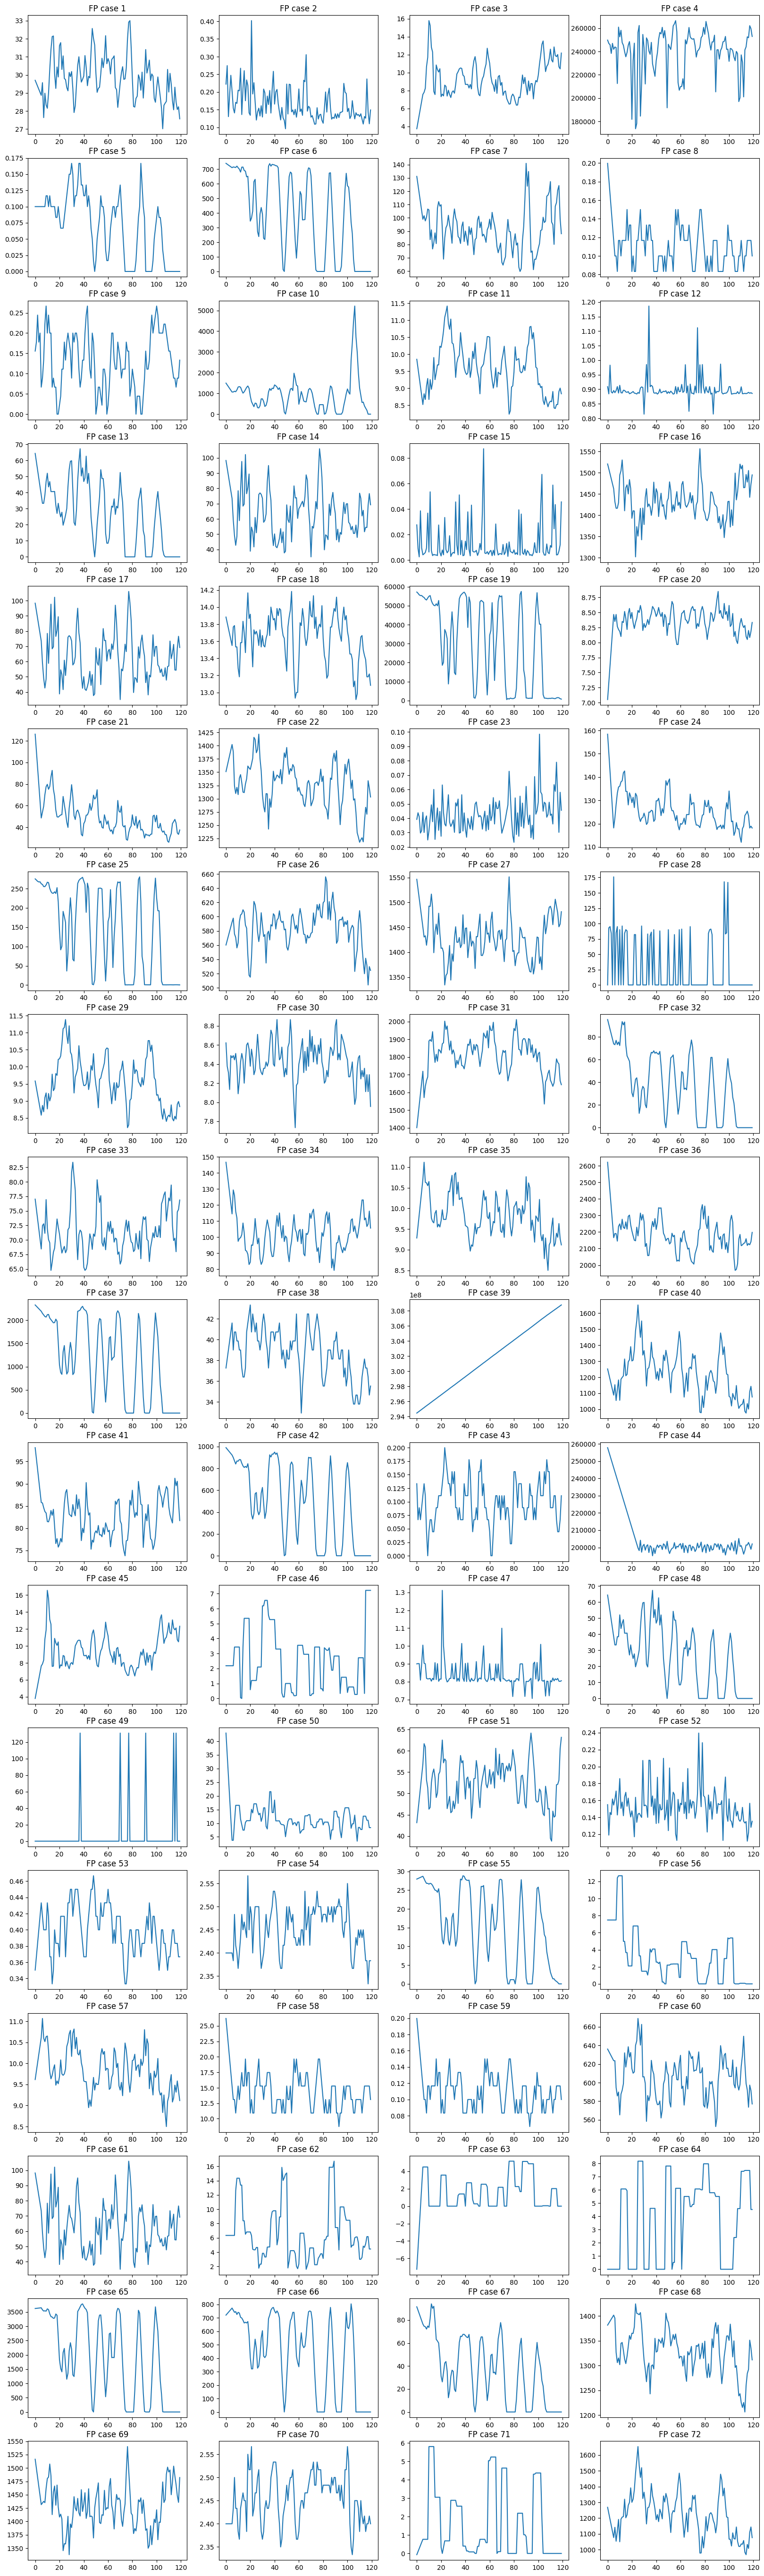

In [38]:
import matplotlib.pyplot as plt
import math

normal_fp_cases = [res["_time_series"] for res in eval_results if res["confusion"] == "FP" and res["method"] == "resid_sum" and res["ground_truth"] == "normal"]
fig, axs = plt.subplots(math.ceil(len(normal_fp_cases)/4), 4, figsize=(20, 70))

for i, (ax, ts) in enumerate(zip(axs.flatten(), normal_fp_cases)):
    ax.plot(ts)
    ax.set_title(f"FP case {i+1}")

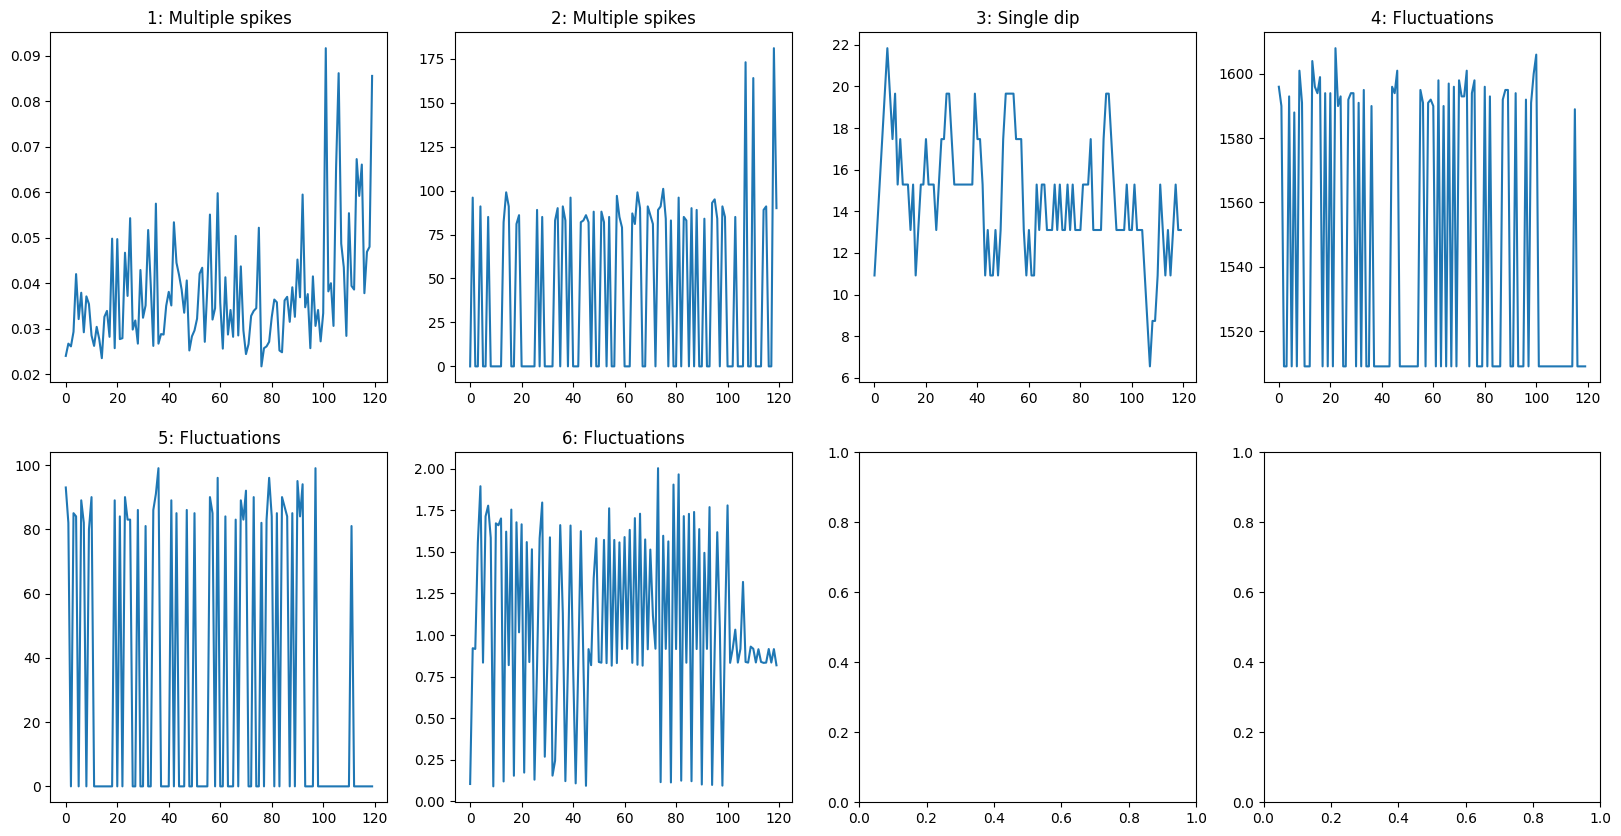

In [39]:
import matplotlib.pyplot as plt
import math

anomaly_fn_cases = [(res["_time_series"], res["raw_pattern"]) for res in eval_results if res["confusion"] == "FN" and res["method"] == "resid_sum" and res["ground_truth"] == "anomaly"]
fig, axs = plt.subplots(math.ceil(len(anomaly_fn_cases)/4), 4, figsize=(20, 10))

for i, (ax, case) in enumerate(zip(axs.flatten(), anomaly_fn_cases)):
    ts, pattern = case
    ax.plot(ts)
    ax.set_title(f"{i+1}: {pattern}")

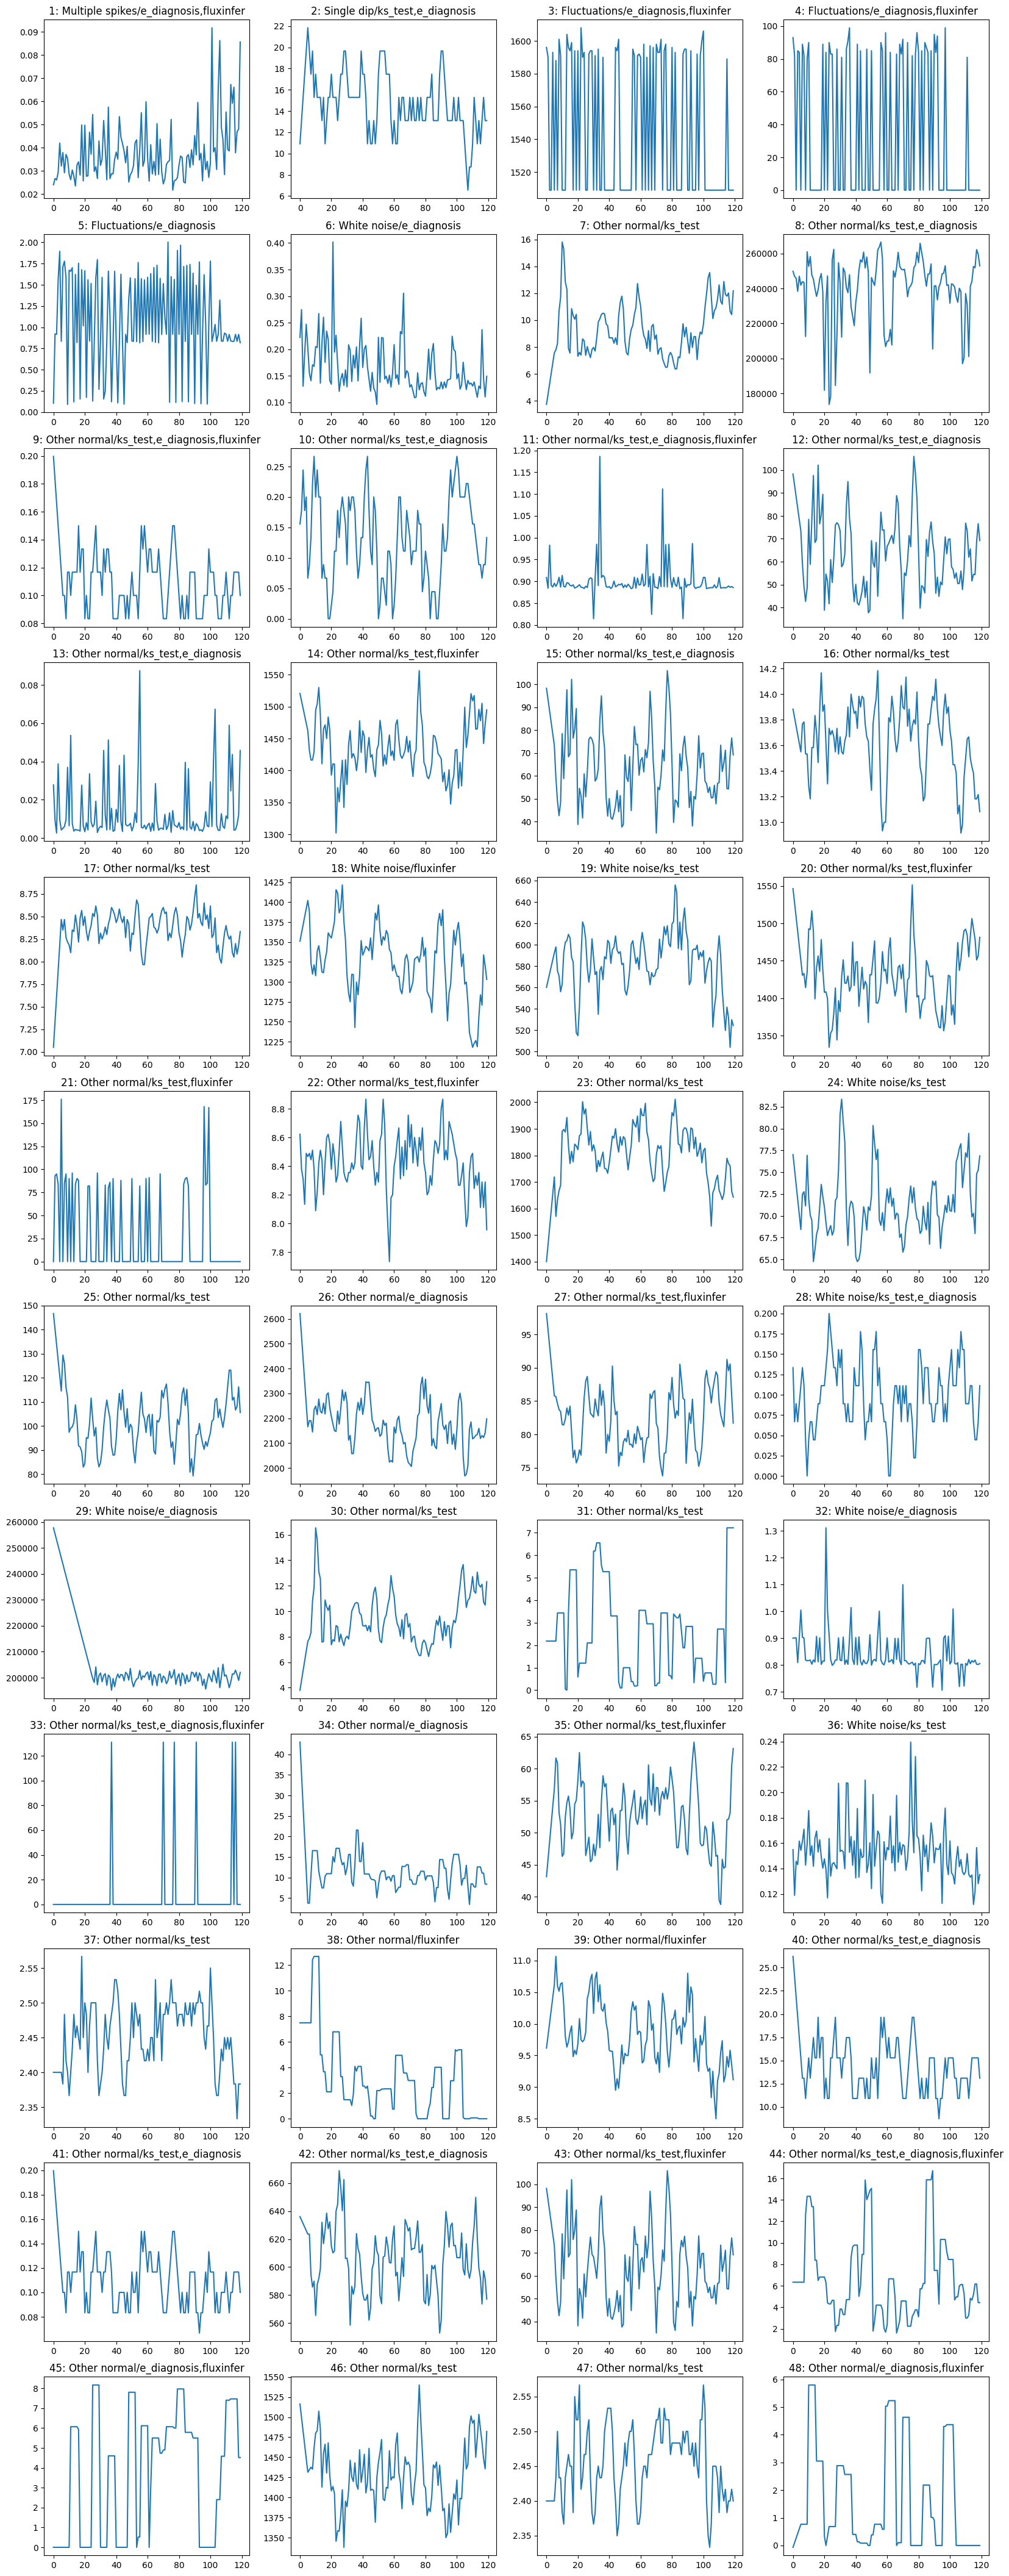

In [40]:
import matplotlib.pyplot as plt
import math

anomaly_inferior_cases = []
num_methods = len(METHODS)
for i in range(0, len(eval_results), num_methods):
    methods_results: list = eval_results[i: i + num_methods]
    resid_sum_res = methods_results[0]
    if resid_sum_res["confusion"] in ["FN", "FP"]:
        other_method_ferior: bool = False
        ferior_methods: list[str] = []
        for other_method_res in methods_results[1:]:
            if other_method_res["confusion"] in ["TP", "TN"]:
                other_method_ferior = True
                ferior_methods.append(other_method_res["method"])

        if other_method_ferior:
            anomaly_inferior_cases.append((resid_sum_res["_time_series"], resid_sum_res["raw_pattern"], ferior_methods))

fig, axs = plt.subplots(math.ceil(len(anomaly_inferior_cases)/4), 4, figsize=(20, 4.5 * len(anomaly_inferior_cases)/4))
for i, (ax, case) in enumerate(zip(axs.flatten(), anomaly_inferior_cases)):
    ts, pattern, ferior_methods = case
    ax.plot(ts)
    ax.set_title(f"{i+1}: {pattern}/{','.join(ferior_methods)}")

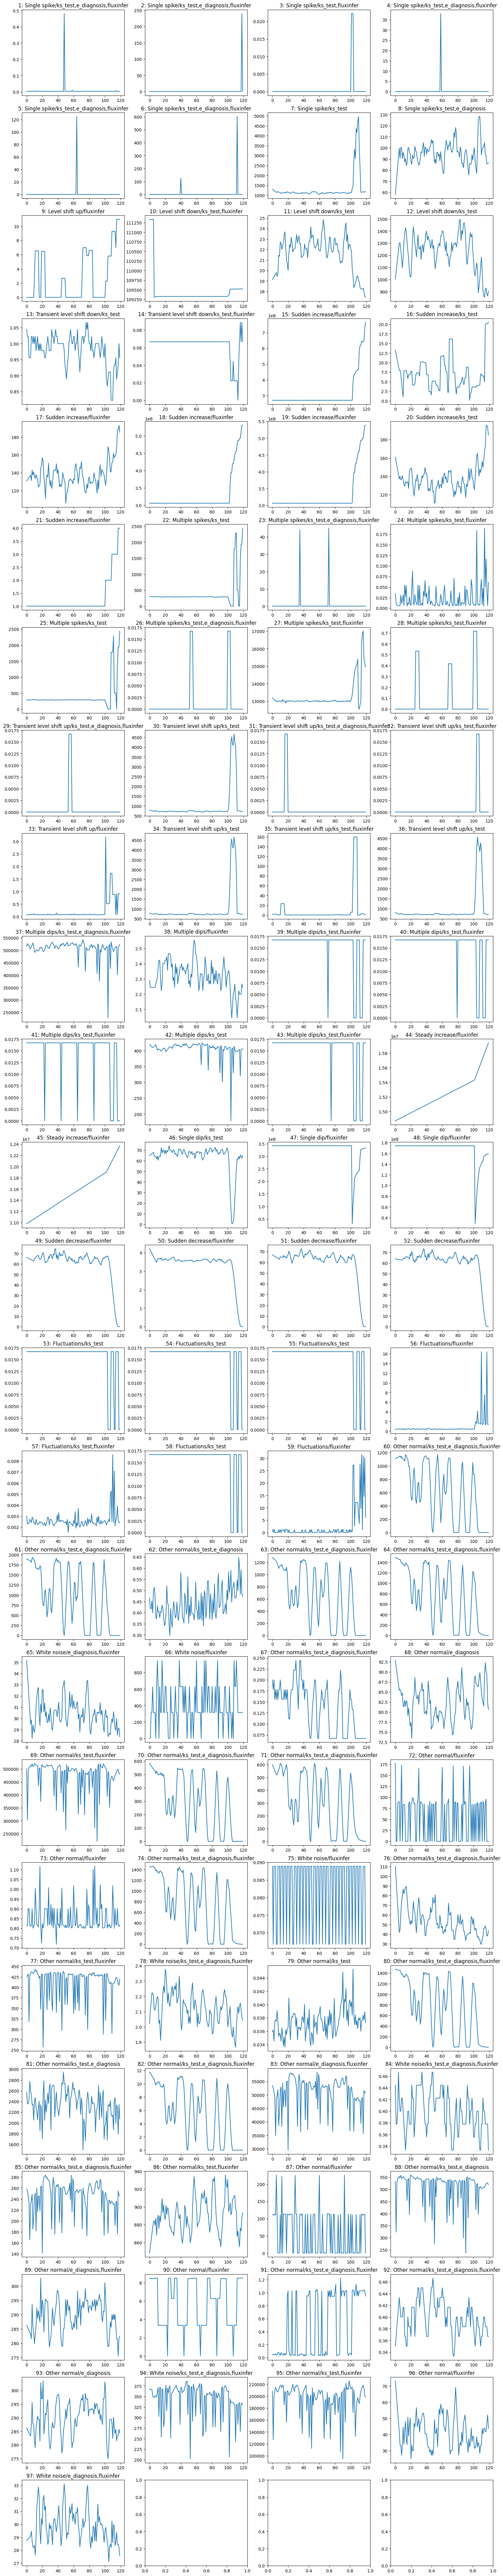

In [41]:
import matplotlib.pyplot as plt
import math

anomaly_ferior_cases = []
num_methods = len(METHODS)
for i in range(0, len(eval_results), num_methods):
    methods_results: list = eval_results[i: i + num_methods]
    resid_sum_res = methods_results[0]
    if resid_sum_res["confusion"] in ["TP", "TN"]:
        other_method_ferior: bool = False
        inferior_methods: list[str] = []
        for other_method_res in methods_results[1:]:
            if other_method_res["confusion"] in ["FP", "FN"]:
                other_method_ferior = True
                inferior_methods.append(other_method_res["method"])

        if other_method_ferior:
            anomaly_ferior_cases.append((resid_sum_res["_time_series"], resid_sum_res["raw_pattern"], inferior_methods))

fig, axs = plt.subplots(math.ceil(len(anomaly_ferior_cases)/4), 4, figsize=(20, 4.5 * len(anomaly_ferior_cases)/4))
for i, (ax, case) in enumerate(zip(axs.flatten(), anomaly_ferior_cases)):
    ts, pattern, inferior_methods = case
    ax.plot(ts)
    ax.set_title(f"{i+1}: {pattern}/{','.join(inferior_methods)}")